# Denoising-CNN

## 1. 构建通用类

In [464]:
import os
import time
import torch
from torch import nn
import torch.utils.data as td
from abc import ABC, abstractmethod

In [669]:
# 定义一个基本的基础的网络
class NeuralNetwork(nn.Module, ABC):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
    
    @property
    def device(self):
#         return "cuda"
        return next(self.parameters()).device

    @abstractmethod
    def forward(self, x):
        pass
    @abstractmethod
    def criterion(self, voutput, vtarget):
        pass

In [670]:

# 定义一个管理网络中参数的管理器
class StatsManager(object):
    def __init__(self):
        self.init()
        
    def __repr__(self):
        return self.__class__.__name__
    
    def init(self):
        self.running_loss=0
        self.number_update=0
        
    def accumulate(self, loss, vinput=None, voutput=None, vtarget=None):
        self.running_loss+=loss
        self.number_update+=1
    
    def summarize(self):
        return self.running_loss/self.number_update

In [671]:
# 定义一个训练的类
class Experiment(object):
    def __init__(self, net, train_set, val_set, optimizer, stats_manager, 
                output_dir = None, batch_size = 16):
    
        # Define data Loaders
        # shuffle=True 在每个新的epoch里面会重新打乱形成新的batch
        # drop_last=True 当样本数量被分割成多个batch的时候，如果还有多的数据（少于batchsize），那么这些样本会被扔掉
        # pin_memory=True 让每个batch形成的张量能更快进入到cuda中
        self.train_loader = td.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
        self.val_loader = td.DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        # Define history
        self.history = []

        # Define checkpoint paths
        if output_dir is None:
            output_dir = "Denoising_{}".format(time.time())
        os.makedirs(output_dir, exist_ok=True)
        checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
        config_path = os.path.join(output_dir, "config.txt")

        # 将全局变量全部转化成字典形式
        maps = {k:v for k, v in locals().items() if k != 'self'}
        self.__dict__.update(maps)

        # 存储checkpoint或者继续加载模型
        if os.path.isfile(self.config_path):
            with open(config_path, 'r') as f:
                if f.read()[:-1] != repr(self):
                    raise ValueError(
                            "Cannot create this experiment: "
                            "I found a checkpoint conflicting with the current setting.")
                else:
                    self.load()
        else:
            self.save()
    
    # 获取当前的epoch
    @property
    def epoch(self):
        return len(self.history)
    
    # 获取当前的网络的配置，用字典返回
    def setting(self):
        return {'Net': self.net,
                'TrainSet': self.train_set,
                'ValSet': self.val_set,
                'Optimizer': self.optimizer,
                'StatsManager': self.stats_manager,
                'BatchSize': self.batch_size}   
    
    # 重写repr内置函数，用字符串的形式返回当前网络的配置
    def __repr__(self):
        string = ''
        for k, v in self.setting().items():
            string += '{} : {} \n'.format(k, v)
        return string
    
    # 返回当前网络训练的状态，用字典的形式
    def state_dict(self):
        return {'Net': self.net.state_dict(),
                'Optimizer': self.optimizer.state_dict(),
                'History': self.history}
        
        
    # 将网络模型(重写的repr返回值)保存在config_path中，同时将网络的state_dict（参数什么的）保存到checkpoint_path
    def save(self):
        torch.save(self.state_dict(), self.checkpoint_path)
        with open(self.config_path, 'w') as f:
            print(self, file=f)
    
    
    # 读取检查点，进行装载
    def load(self):
        checkpoint = torch.load(self.checkpoint_path, map_location=self.net.device)
        self.net.load_state_dict(checkpoint['Net'])
        self.optimizer.load_state_dict(checkpoint['Optimizer'])
        self.history = checkpoint['History']
#         for state in self.optimizer.state.values():
#             for k, v in state.items():
#                 if isinstance(v, torch.Tensor):
#                     state[k] = v.to(self.net.device)
        del checkpoint
        
        
    def run(self, num_epochs, plot=None):
        # 设置网络的状态是train状态(mode=True)，而不是eval状态(mode=False)，这只对某些特定的模块有作用
        self.net.train(mode=True)
        self.stats_manager.init()
        start_epoch = self.epoch
        print("Start/Continue training from epoch {}".format(start_epoch))
        
        if(plot is not None):
            plot(self)
        
        for epoch in range(start_epoch, num_epochs):
            s = time.time()
            # 每一个新的epoch都要重新计算loss
            self.stats_manager.init()
            for vinput, vtarget in self.train_loader:
                # 将变量挂载到CPU或者GPU
                vinput = vinput.to(self.net.device)
                vtarget = vtarget.to(self.net.device)
                # 将优化器里面的梯度全部清空
                self.optimizer.zero_grad()
                # 开始前向传播
                voutput = self.net.forward(vinput)
                # 计算loss
                loss = self.net.criterion(voutput, vtarget)
                # 根据loss计算梯度
                loss.backward()
                # 利用优化器进行单次权值w更新
                self.optimizer.step()
                
                # loss.item()是将loss这个零维张量转化成浮点数
                with torch.no_grad():
                    self.stats_manager.accumulate(loss.item(), vinput, voutput, vtarget)
            # 将每次epoch中的loss加入到history中    
            self.history.append(self.stats_manager.summarize())
            # 输出每一轮的loss
            print('Epoch {}  Time:{}  Loss:{}'.format(self.epoch, time.time()-s, self.stats_manager.summarize()))
            # 每一个epoch后都对模型和训练过程进行保存
            self.save()
            if plot is not None:
                plot(self)
                
        print("Finish training for {} epochs".format(num_epochs))
            
    
    def evaluate(self):
        self.stats_manager.init()
        # 指定是eval模式
        self.net.eval()
        with torch.no_grad():
            for vinput, vtarget in self.val_loader:
                vinput = vinput.to(self.net.device)
                vtarget = vtarget.to(self.net.device)
                voutput = self.net.forward(vinput)
                loss = self.net.criterion(voutput, vtarget)
                self.stats_manager.accumulate(loss.item(), vinput, voutput, vtarget)
        # 如果是在训练过程中使用eval评估当前状态，那么就要使用train模式
        self.net.train()
        return self.stats_manager.summarize()

In [672]:
# 设置跑网络的设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## 2. 准备数据集

In [673]:
%matplotlib inline
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import time

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import maxabs_scale
import copy

制造训练集相关类

In [674]:
# 对训练集和测试集进行预处理
class GetTraindata:
    def __init__(self, path):
        clean_filenames = [filename for filename in os.listdir(os.path.join(path, '干净信号txt')) if os.path.isfile(os.path.join(path, '干净信号txt', filename))]
        noisy_filenames = [filename for filename in os.listdir(os.path.join(path, '带噪信号txt')) if os.path.isfile(os.path.join(path, '带噪信号txt', filename))]
        clean_filenames.sort(key = lambda x:int(x[:-4]))
        noisy_filenames.sort(key = lambda x:int(x[:-4]))
        
        clean_signal = []
        noisy_signal = []
        for file_name in clean_filenames:
            clean_signal.append(np.loadtxt(os.path.join(path, '干净信号txt', file_name)))
        for file_name in noisy_filenames:
            noisy_signal.append(np.loadtxt(os.path.join(path, '带噪信号txt', file_name)))
        
        clean_signal = np.array(clean_signal)
        noisy_signal = np.array(noisy_signal)
        
        # 进行归一化处理， fit_transforn进行计算数据集固有属性（fit），同时进行转化， tranform在已经计算好的fit上进行转化， invers_tainsform()将数据集转化回来
#         self.max_abs_scaler = MaxAbsScaler()
#         data = np.concatenate((clean_signal,noisy_signal),axis=0)
#         self.max_abs_scaler.fit_transform(data)
        
        clean_signal = maxabs_scale(clean_signal, axis=1)
        noisy_signal = maxabs_scale(noisy_signal)
        
        # 将一维信号转化成[通道数， 长， 宽]格式
        self.clean_signal = clean_signal[:, np.newaxis, :]
        self.noisy_signal = noisy_signal[:, np.newaxis, :]
        
    def get_scaler(self):
        return self.max_abs_scaler
    
    def get_data(self):
        return self.clean_signal, self.noisy_signal
    
#     def get_origin_data(self):
#         clean_orgin_signal = self.max_abs_scaler.invers_transform(clean_signal)
#         noisy_orgin_signal = self.max_abs_scaler.invers_transform(noisy_signal)

In [675]:
# 将数据装载到clean当中, data为数据集合， num为eval模式下的数据数量
class GetDataset(Dataset):
    def __init__(self, data, num):
        self.mode = "train"   # train模式使用train数据， eval模式使用eval数据
        clean_signal = data[0]
        noisy_signal = data[1]
        self.eval_clean_signal = clean_signal[:num]
        self.eval_noisy_signal = noisy_signal[:num]
        self.train_clean_signal = clean_signal[num:]
        self.train_noisy_signal = noisy_signal[num:]
    
    # 返回的是一个2*1*2001   ([1, 2001], [1, 2001])
    def __getitem__(self, index):
        clean = []
        noisy = []
        if(self.mode == "train"):
            clean = self.train_clean_signal[index]
            noisy = self.train_noisy_signal[index]
        elif(self.mode == "eval"):
            clean = self.eval_clean_signal[index]
            noisy = self.eval_noisy_signal[index]
        
        clean = torch.Tensor(clean)
        noisy = torch.Tensor(noisy)
        
        return noisy, clean
    
    def __len__(self):
        if(self.mode == "train"):
            return len(self.train_clean_signal)
        else:
            return len(self.eval_clean_signal)
            
    def train(self):
        self.mode = "train"  
        return self.mode
        
    def eval(self):
        self.mode = "eval"
        return self.mode

导入数据集

In [676]:
dataset_path = "./dataset"

In [677]:
data = GetTraindata(dataset_path)
data_set = GetDataset(data.get_data(), 15)
data_set.train()
train_set = copy.deepcopy(data_set)
data_set.eval()
test_set = copy.deepcopy(data_set)

In [678]:
print(data.get_data()[0].shape)
print(data_set[0][0].shape)

(501, 1, 2001)
torch.Size([1, 2001])


In [727]:
# 设计一个我的画图
def mysignalshow(signal, ax = plt):
#     print(signal)
#     print(signal.shape)
    # 将张量转化成数据
    signal = signal.to('cpu').numpy()[0]
    ax.plot(np.array(signal))

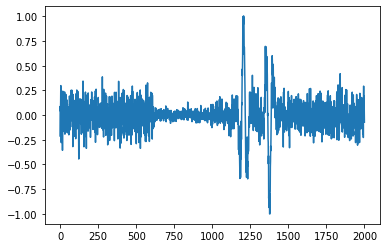

In [728]:
mysignalshow(data_set[0][0])

## 3. DnCNN

实现DnCNN的网络

In [681]:
class DnCNN(NeuralNetwork):
    def __init__(self, D , C=64):
        super(DnCNN, self).__init__()
        self.D = D
        self.mse = nn.MSELoss()
        # 用于保留最后一个batch中所有的特征
        self.features = []
        
        # 开始搭建卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv1d(1, C, 3, padding = 1))
        self.conv.extend([nn.Conv1d(C, C, 3, padding = 1) for _ in range(D)])
        self.conv.append(nn.Conv1d(C, 1, 3, padding = 1))
        
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv)):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # 设置bn层
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm1d(C) for _ in range(D)])
        for i in range(len(self.bn)):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))
            
    def forward(self, vinput):
        self.features.clear()
        D = self.D
        h = F.leaky_relu(self.conv[0](vinput))
        self.features.append(h)
        for i in range(D):
            h = F.leaky_relu(self.bn[i](self.conv[i+1](h)))
            self.features.append(h)
        voutput = self.conv[D+1](h) + vinput
        return voutput
    
    # 损失函数使用均方误差
    def criterion(self, voutput, vtarget):
        return self.mse(voutput, vtarget)

随便跑一跑

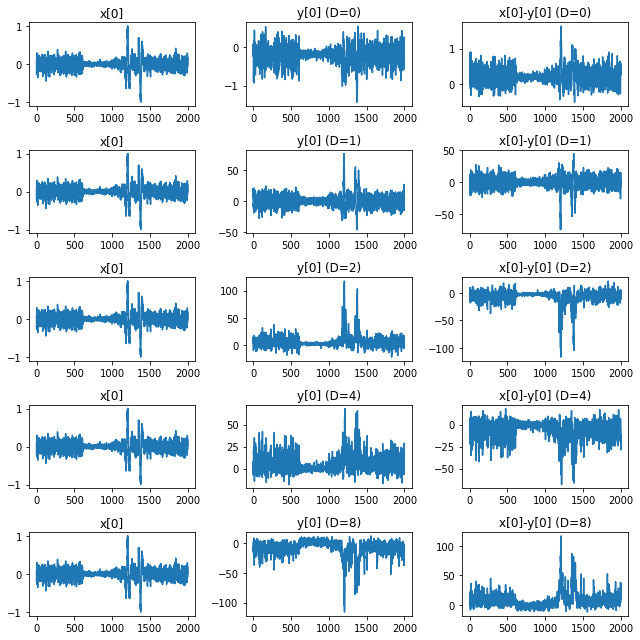

In [682]:
data_set.train()
x,t = data_set[0]
# 给数据添加一个维度来代表batch-size
x = x.unsqueeze(0).to(device)
Dnum = [0, 1, 2, 4, 8]



fig, axes = plt.subplots(nrows=len(Dnum), ncols = 3, figsize=(9, 9))
for i in range(len(Dnum)):
    with torch.no_grad():
        model = DnCNN(Dnum[i]).to(device)
        y = model(x)

    mysignalshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    mysignalshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Dnum[i]})')
    mysignalshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Dnum[i]})')
#     mysignalshow(t, ax=axes[i][3])
#     axes[i][3].set_title(f'clean (D={Dnum[i]})')
    plt.tight_layout()



实现下DnCNN的StatsManager

In [683]:
class DenoisingStatsManager(StatsManager):
    def __init__(self):
        super(DenoisingStatsManager, self).__init__()
    
    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0
        
    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d) 
        n = x.shape[0] * x.shape[1] * x.shape[2] 
        self.running_psnr += 10*torch.log10(3*n/(torch.norm(y-d)**2))
        
    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu()}

In [684]:
def plot(exp, fig, axes, noisy, clean, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    mysignalshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy signal')
    
    mysignalshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised signal')
    
    mysignalshow(clean, ax=axes[0][2])
    axes[0][2].set_title('Clean signal')
    
    axes[1][0].plot([exp.history[k]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    plt.tight_layout()
    fig.canvas.draw()

DnCNN开始训练

In [688]:
lr = 1e-3
net = DnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=10, 
               output_dir="./checkpoints/denoising1")


Start/Continue training from epoch 0
Epoch 1  Time:1.1232502460479736  Loss:{'loss': 5.78306345269084, 'PSNR': tensor(0.5212)}
Epoch 2  Time:1.0012311935424805  Loss:{'loss': 0.44145248271524906, 'PSNR': tensor(8.4597)}
Epoch 3  Time:1.0032286643981934  Loss:{'loss': 0.23092846355090538, 'PSNR': tensor(11.2062)}
Epoch 4  Time:0.9352085590362549  Loss:{'loss': 0.1504304287955165, 'PSNR': tensor(13.0754)}
Epoch 5  Time:0.9642162322998047  Loss:{'loss': 0.10676115797832608, 'PSNR': tensor(14.5249)}
Epoch 6  Time:0.9672181606292725  Loss:{'loss': 0.07973933902879556, 'PSNR': tensor(15.7940)}
Epoch 7  Time:1.0232253074645996  Loss:{'loss': 0.06740149684871237, 'PSNR': tensor(16.5234)}
Epoch 8  Time:1.0942444801330566  Loss:{'loss': 0.05308438193363448, 'PSNR': tensor(17.5680)}
Epoch 9  Time:0.9892208576202393  Loss:{'loss': 0.04421527101658285, 'PSNR': tensor(18.3520)}
Epoch 10  Time:1.0572433471679688  Loss:{'loss': 0.03913906907352308, 'PSNR': tensor(18.8916)}
Epoch 11  Time:0.94621276855

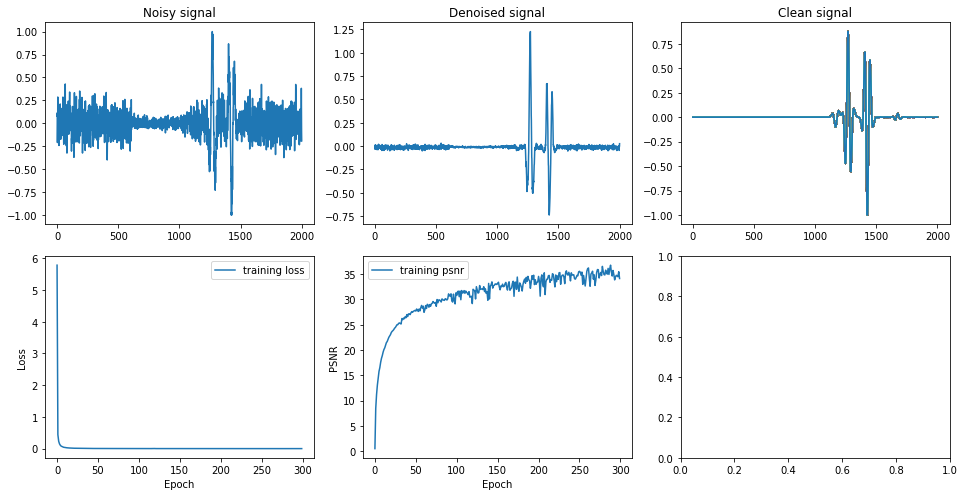

In [689]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp1.run(num_epochs=300, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[0][0], clean=test_set[0][1]))

## 4. UDnCNN

In [690]:
class UDnCNN(NeuralNetwork):
    def __init__(self, D , C=64):
        super(UDnCNN, self).__init__()
        self.D = D
        self.mse = nn.MSELoss()
        self.features = []
        
        # 开始搭建卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv1d(1, C, 3, padding = 1))
        self.conv.extend([nn.Conv1d(C, C, 3, padding = 1) for _ in range(D)])
        self.conv.append(nn.Conv1d(C, 1, 3, padding = 1))
        
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv)):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # 设置bn层
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm1d(C) for _ in range(D)])
        for i in range(len(self.bn)):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))
    # 前面都一样，这里搞个U-Net        
    def forward(self, vinput):
        self.features.clear()
        D = self.D
        h = F.relu(self.conv[0](vinput))
        self.features.append(h)
        h_buff = []
        idx_buff = []
        shape_buff = []
        for i in range(D//2-1):
            shape_buff.append(h.shape)
            h, idx = F.max_pool1d(F.leaky_relu(self.bn[i](self.conv[i+1](h))),
                                 kernel_size=3, return_indices=True)
            h_buff.append(h)
            self.features.append(h)
            idx_buff.append(idx)
        for i in range(D//2-1, D//2+1):
            h = F.leaky_relu(self.bn[i](self.conv[i+1](h)))
            self.features.append(h)
        for i in range(D//2+1, D):
            j = i - (D//2+1) + 1
            h = F.max_unpool1d(F.leaky_relu(self.bn[i](self.conv[i+1]((h+h_buff[-j])/np.sqrt(2)))), 
                               idx_buff[-j], kernel_size=3, output_size=shape_buff[-j])
            self.features.append(h)
        voutput = self.conv[D+1](h) + vinput
        return voutput
    
    # 损失函数使用均方误差
    def criterion(self, voutput, vtarget):
        return self.mse(voutput, vtarget)

UDnCNN训练

In [691]:
lr = 1e-3
net = UDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp2 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=10, 
               output_dir="./checkpoints/denoising2")

Start/Continue training from epoch 0
Epoch 1  Time:1.1672663688659668  Loss:{'loss': 10.641605168581009, 'PSNR': tensor(-4.9720)}
Epoch 2  Time:1.1532609462738037  Loss:{'loss': 3.237561583518982, 'PSNR': tensor(-0.2058)}
Epoch 3  Time:1.0992422103881836  Loss:{'loss': 1.5996465062101681, 'PSNR': tensor(2.7928)}
Epoch 4  Time:1.1912641525268555  Loss:{'loss': 0.9322997766236464, 'PSNR': tensor(5.1171)}
Epoch 5  Time:1.234297513961792  Loss:{'loss': 0.5890474667151769, 'PSNR': tensor(7.1105)}
Epoch 6  Time:1.162269115447998  Loss:{'loss': 0.39224147858719033, 'PSNR': tensor(8.8744)}
Epoch 7  Time:1.1282298564910889  Loss:{'loss': 0.27061170277496177, 'PSNR': tensor(10.4768)}
Epoch 8  Time:1.1444408893585205  Loss:{'loss': 0.18881267992158732, 'PSNR': tensor(12.0508)}
Epoch 9  Time:1.159278154373169  Loss:{'loss': 0.13803534861654043, 'PSNR': tensor(13.4215)}
Epoch 10  Time:1.1532683372497559  Loss:{'loss': 0.10599889745935798, 'PSNR': tensor(14.5591)}
Epoch 11  Time:1.1602671146392822  

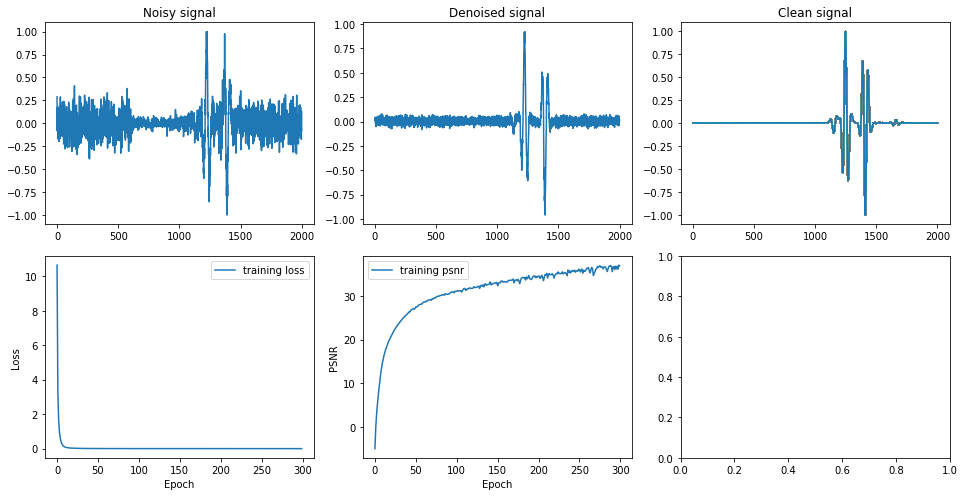

In [692]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp2.run(num_epochs=300, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[11][0], clean=test_set[5][1]))

## 5. DUDnCNN
U-net like CNNs with dilated convolutions

空洞卷积(dilated convolution)代替池化来增大感受野(Receptive Field)

然而 pytorch 空洞卷积跑的贼慢，原理上看应该和普通卷积差不多快，这里有个优化的问题...

空洞卷积之前 torch.backends.cudnn.benchmark=True 之后改回 torch.backends.cudnn.benchmark=False 可以提速，详见 https://github.com/pytorch/pytorch/issues/15054.

In [696]:
class DUDnCNN(NeuralNetwork):

    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        self.mse = nn.MSELoss()
        self.features = []
        
        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        # 空洞卷积
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        
        # 卷积层
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv1d(1, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv1d(C, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv1d(C, 1, 3, padding=dilations[-1], dilation=dilations[-1]))
        # Kaiming正态分布初始化，又叫啥He('s) initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='leaky_relu')
        
        # batch norm
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm1d(C, C) for _ in range(D)])
        # Batch norm layer 初始化权值
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        self.features.clear()
        D = self.D
        h = F.leaky_relu(self.conv[0](x))
        self.features.append(h)
        h_buff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            h_buff.append(h)
            self.features.append(h)
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            self.features.append(h)
            
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.leaky_relu(self.bn[i](h))
            self.features.append(h)
            
        y = self.conv[D+1](h) + x
        return y
    
    # 损失函数使用均方误差
    def criterion(self, voutput, vtarget):
        return self.mse(voutput, vtarget)

In [697]:
lr = 1e-3
net = DUDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=10, 
               output_dir="./checkpoints/denoising3")

Start/Continue training from epoch 0
Epoch 1  Time:1.0982472896575928  Loss:{'loss': 0.00752103716028311, 'PSNR': tensor(28.2260)}
Epoch 2  Time:1.0547528266906738  Loss:{'loss': 0.001435632858677612, 'PSNR': tensor(33.2737)}
Epoch 3  Time:1.111307144165039  Loss:{'loss': 0.0010211652855408222, 'PSNR': tensor(34.7180)}
Epoch 4  Time:0.9842195510864258  Loss:{'loss': 0.0008539518688242728, 'PSNR': tensor(35.4975)}
Epoch 5  Time:1.0831665992736816  Loss:{'loss': 0.0007082048189962128, 'PSNR': tensor(36.2912)}
Epoch 6  Time:1.150259256362915  Loss:{'loss': 0.0006204796579064956, 'PSNR': tensor(36.8640)}
Epoch 7  Time:1.0353355407714844  Loss:{'loss': 0.0005821103992881641, 'PSNR': tensor(37.1548)}
Epoch 8  Time:1.0572357177734375  Loss:{'loss': 0.0005312612095925336, 'PSNR': tensor(37.5400)}
Epoch 9  Time:1.1195294857025146  Loss:{'loss': 0.00047660622476541903, 'PSNR': tensor(38.0159)}
Epoch 10  Time:1.0382301807403564  Loss:{'loss': 0.00045812764316603233, 'PSNR': tensor(38.1831)}
Epoch

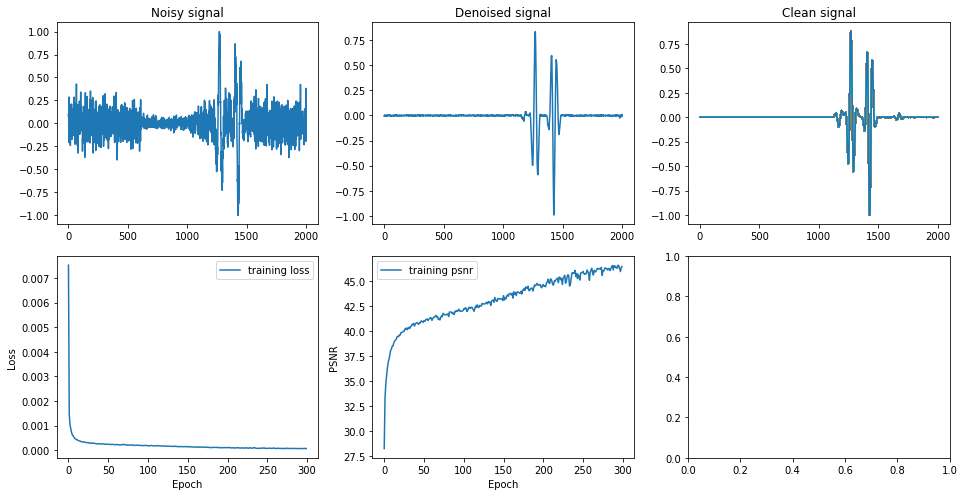

In [698]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13.5, 7))
exp3.run(num_epochs=300, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[0][0], clean=test_set[0][1]))

## 6. 比较`DnCNN` `UDnCNN` `DUDnCNN`

看下三个网络的loss和PSNR

In [701]:
# DnCNN
exp1.evaluate()

{'loss': 0.0023939621169120073, 'PSNR': tensor(30.9800)}

In [702]:
# UDnCNN
exp2.evaluate()

{'loss': 0.0009344610152766109, 'PSNR': tensor(35.0656)}

In [703]:
# DUDnCNN
exp3.evaluate()

{'loss': 0.0005049034371040761, 'PSNR': tensor(37.7391)}

看下三个网络处理的效果

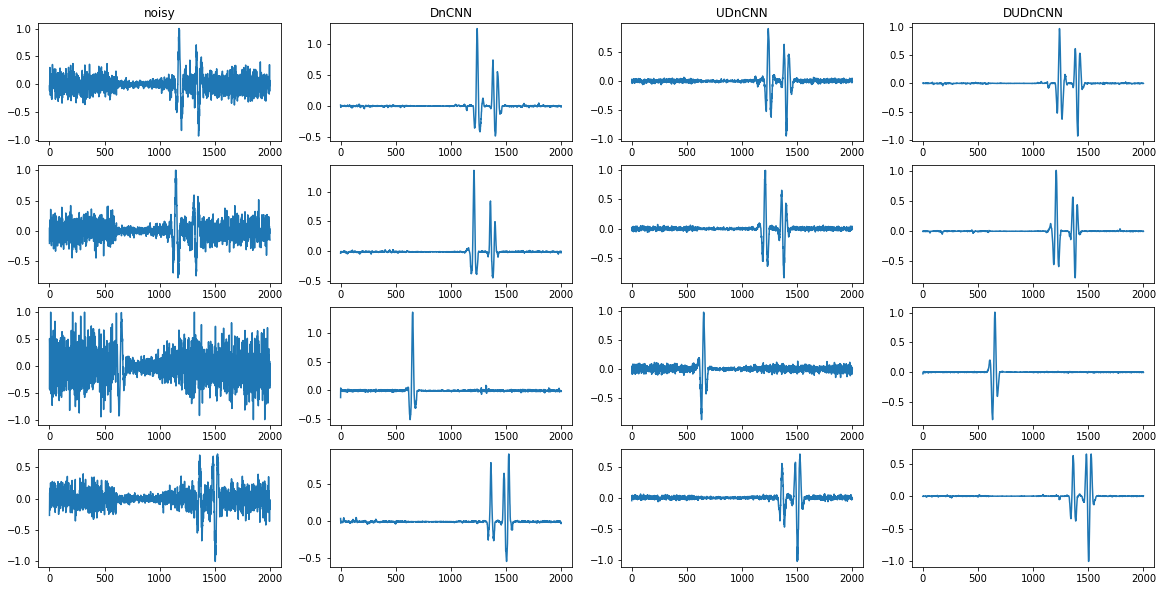

In [704]:
num = 2 
signal = []
nets = [exp1.net, exp2.net, exp3.net]
titles = ['noisy', 'DnCNN', 'UDnCNN', 'DUDnCNN']

fig, axes = plt.subplots(ncols=4, nrows=num*2, figsize=(20,10))

for i in range(num):
    mysignalshow(train_set[7*i+7][0], ax=axes[i][0])
    x, _ = test_set[7*i+7]
    x = x.unsqueeze(0).to(device)
    signal.append(x)
    
for i in range(1,num+1):
    mysignalshow(train_set[200*i+7][0], ax=axes[i+num-1][0])
    x, _ = train_set[200*i+7]
    x = x.unsqueeze(0).to(device)
    signal.append(x)  
    
for i in range(num*2):
    for j in range(len(nets)):
        model = nets[j].to(device)
        model.eval()
        with torch.no_grad():
            y = model.forward(signal[i])
        mysignalshow(y[0], ax=axes[i][j+1])
for i in range(1):
    for j in range(len(titles)):
        axes[i][j].set_title(f'{titles[j]}')

## 7. 提取特征图

In [705]:
# 设计一个我的画图
def MyFeatureShow(feature, ax = plt):
    feature = feature.to('cpu').numpy()
    feature = np.sum(feature, axis = 1)[0]
    ax.plot(feature)

In [706]:
def MyFeaturesShow(model, name):
    fig, axes = plt.subplots(2, 3, figsize = (20, 10))
    
    MyFeatureShow(model.features[0], ax=axes[0][0])
    axes[0][0].set_title('{}_conv1'.format(name))
    
    MyFeatureShow(model.features[1], ax=axes[0][1])
    axes[0][1].set_title('{}_conv2'.format(name))
    
    MyFeatureShow(model.features[2], ax=axes[0][2])
    axes[0][2].set_title('{}_conv3'.format(name))
    
    MyFeatureShow(model.features[3], ax=axes[1][0])
    axes[1][0].set_title('{}_conv4'.format(name))
    
    MyFeatureShow(model.features[4], ax=axes[1][1])
    axes[1][1].set_title('{}_conv5'.format(name))
    
    MyFeatureShow(model.features[5], ax=axes[1][2])
    axes[1][2].set_title('{}_conv6'.format(name))
    
    plt.tight_layout()
    
    plt.savefig(r'C:\Users\bbfss\Desktop\Code\github\Denoising-CNN\重写\结果集\特征集\{}_features.svg'.format(name))

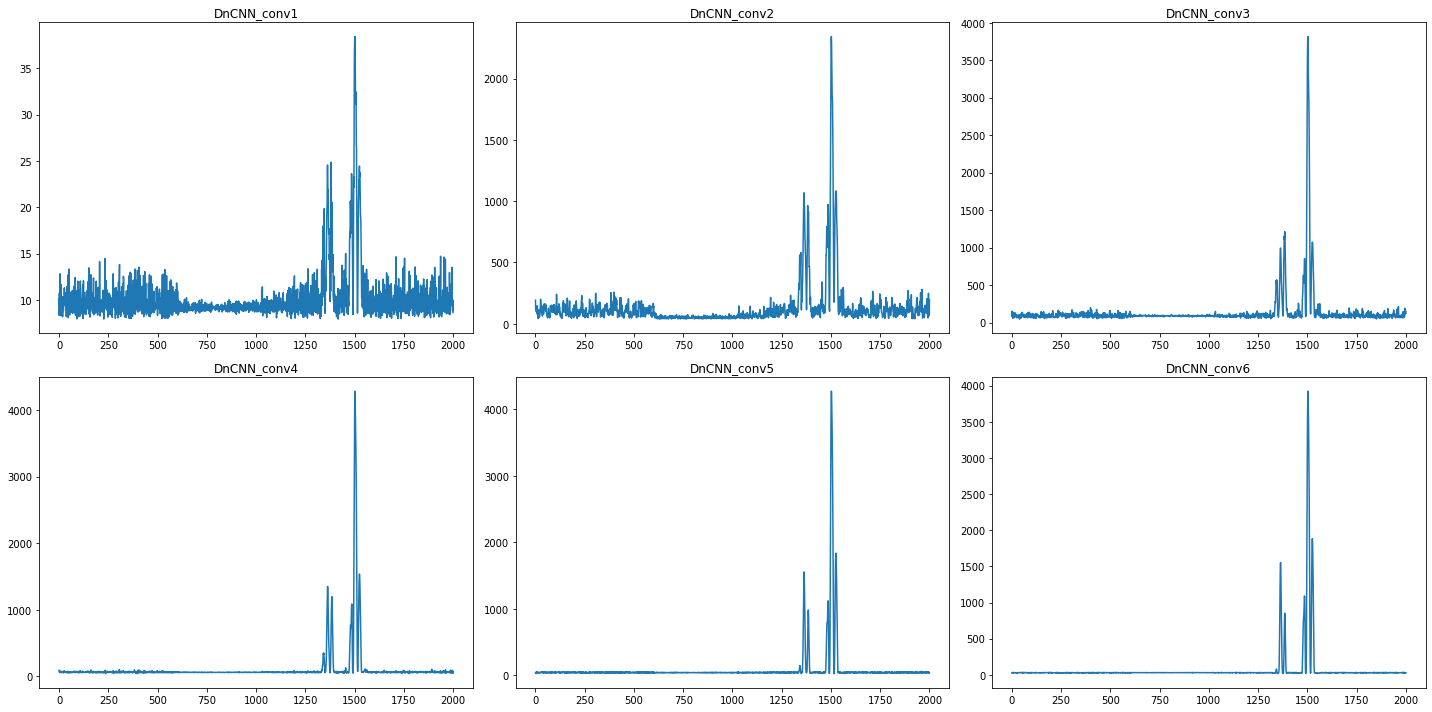

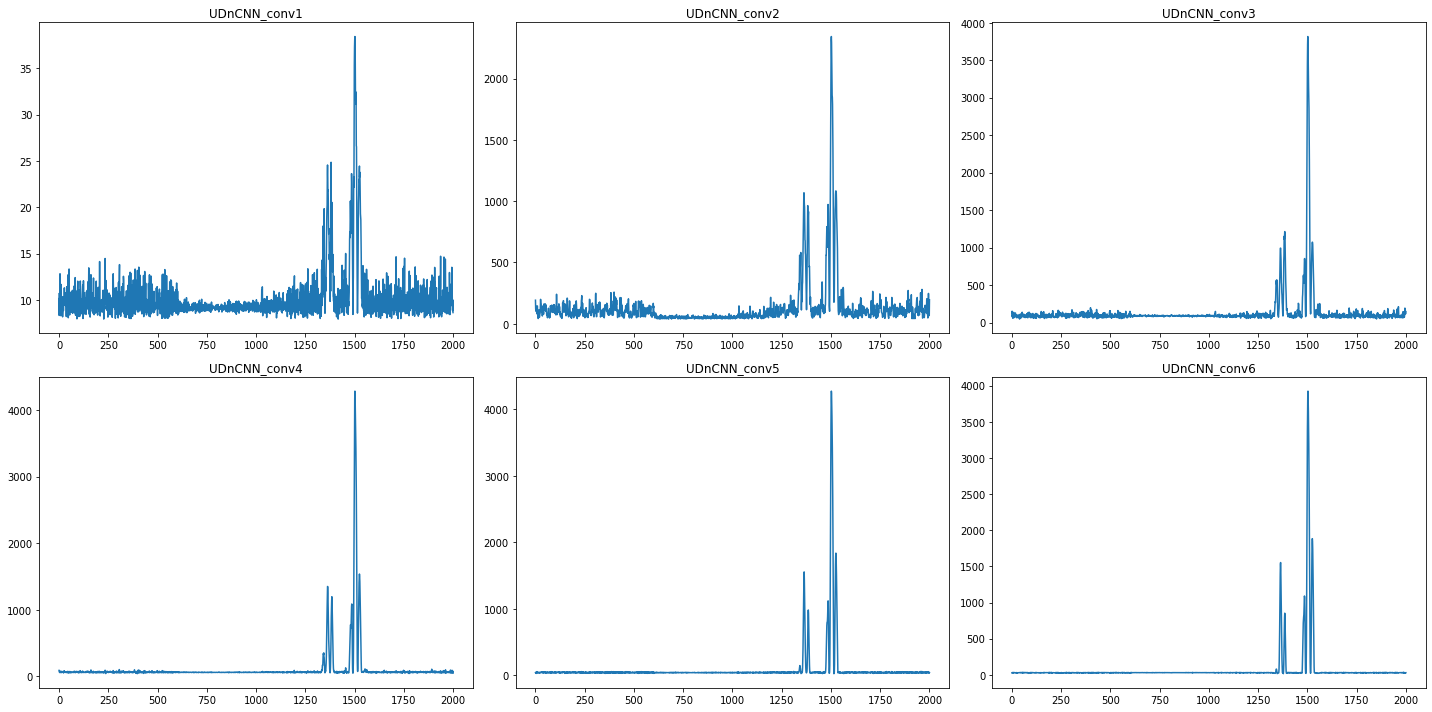

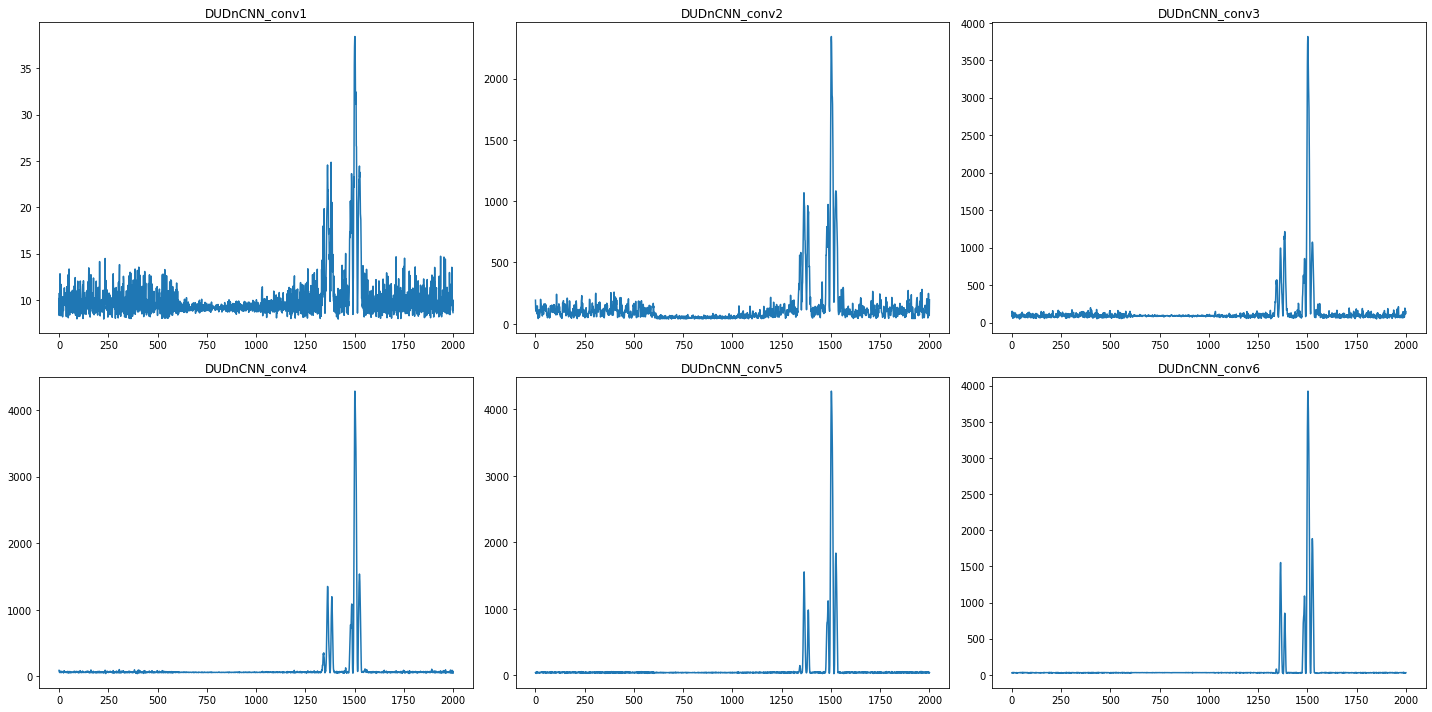

In [707]:
MyFeaturesShow(nets[0], titles[1])
MyFeaturesShow(nets[0], titles[2])
MyFeaturesShow(nets[0], titles[3])

## 8.保存结果集

In [734]:
def mysignalshow(signal, ax = plt):
    # 将张量转化成数据
    plt.xlim(0, 2001)
    plt.ylim(-1, 1)
    signal = signal.to('cpu').numpy()[0]
    ax.plot(np.array(signal))

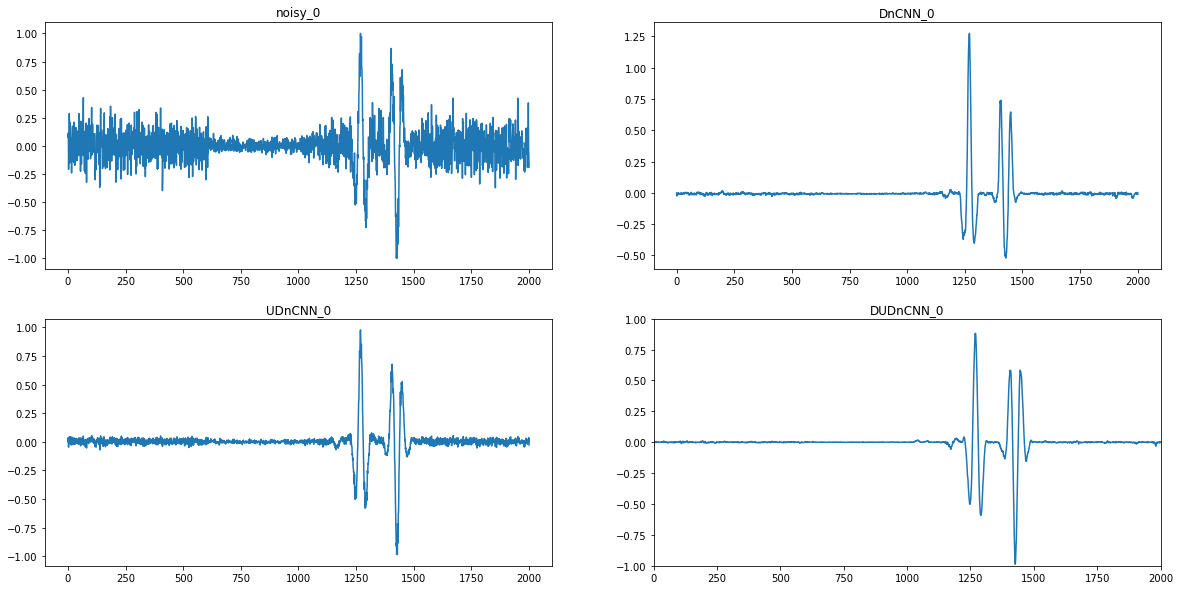

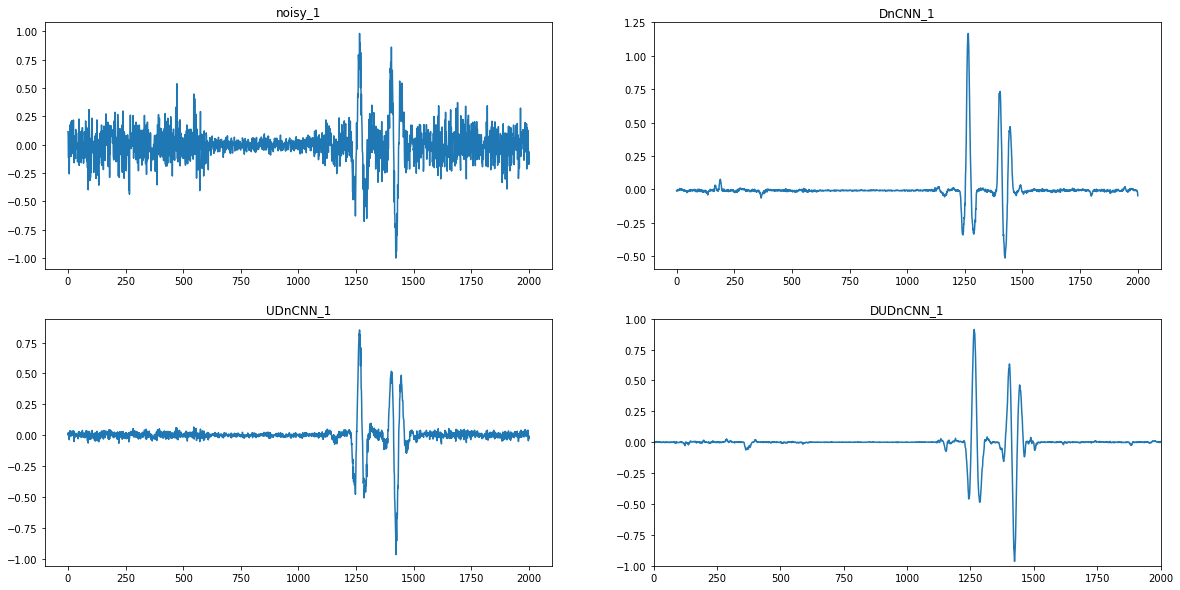

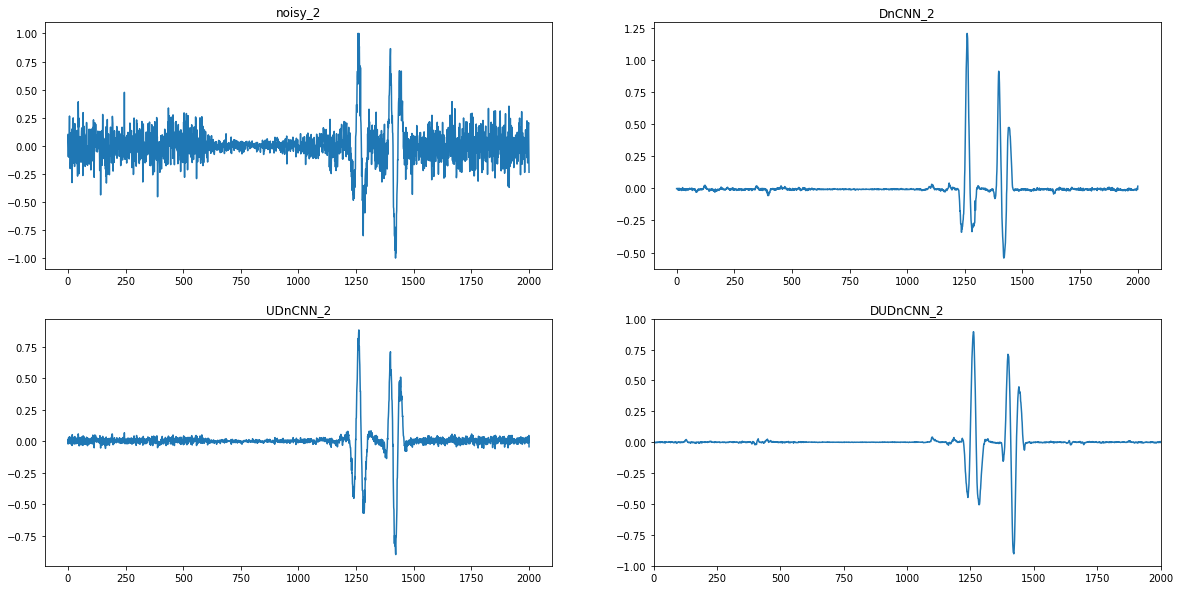

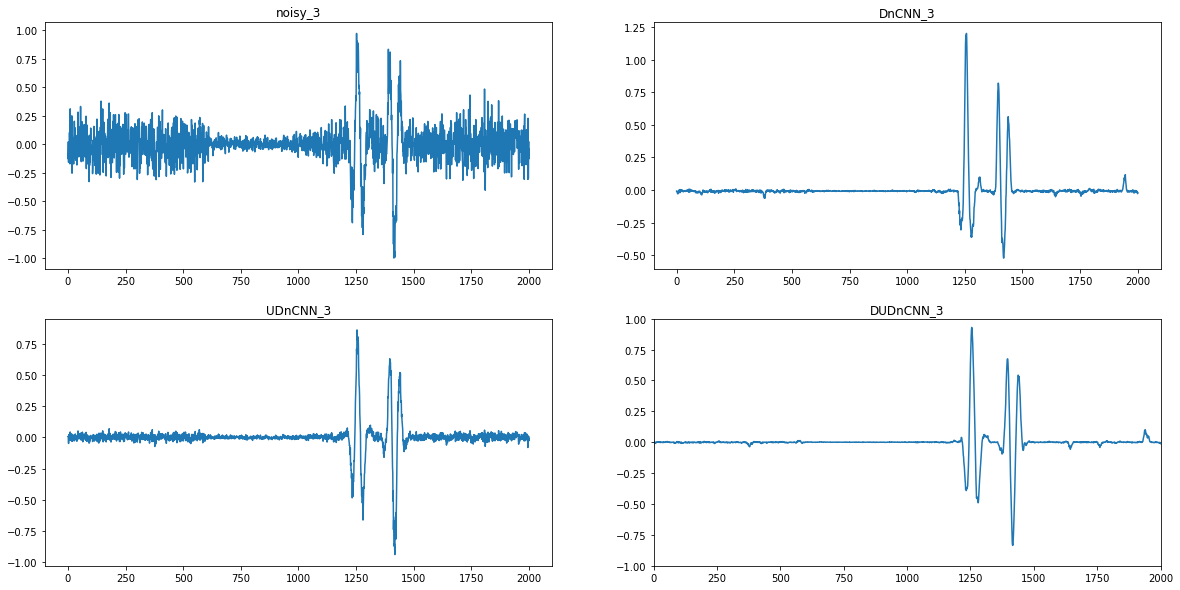

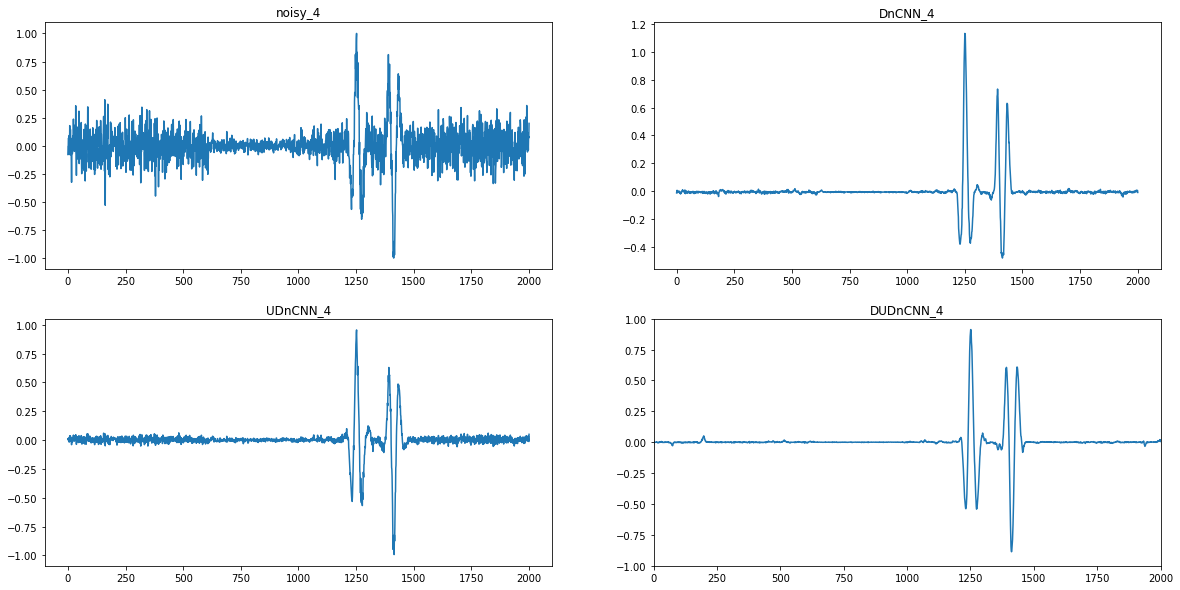

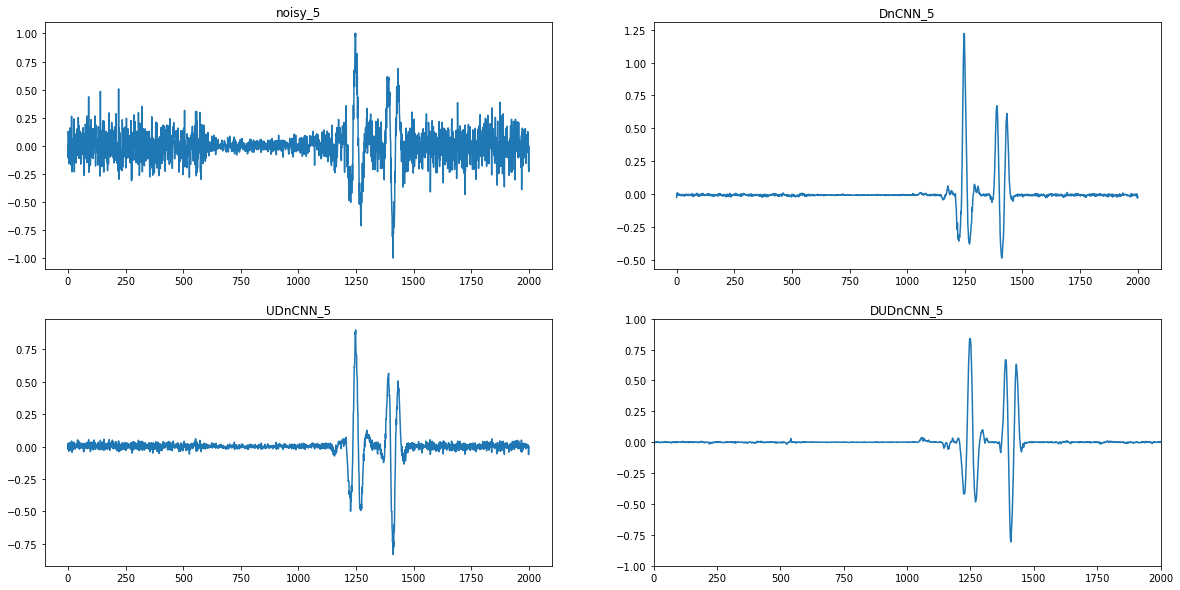

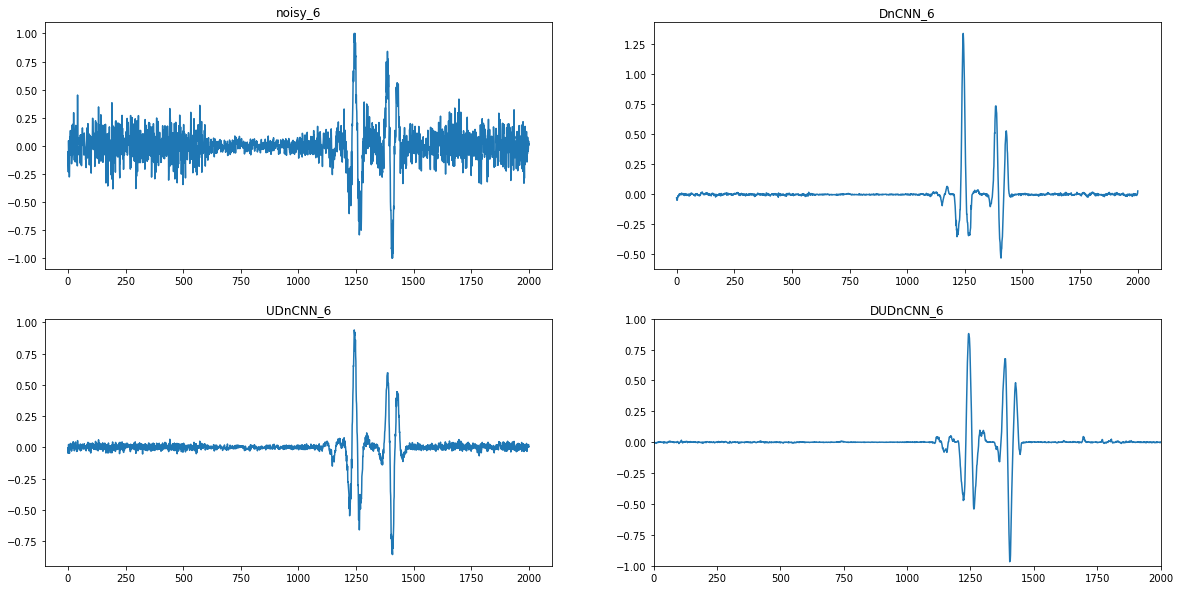

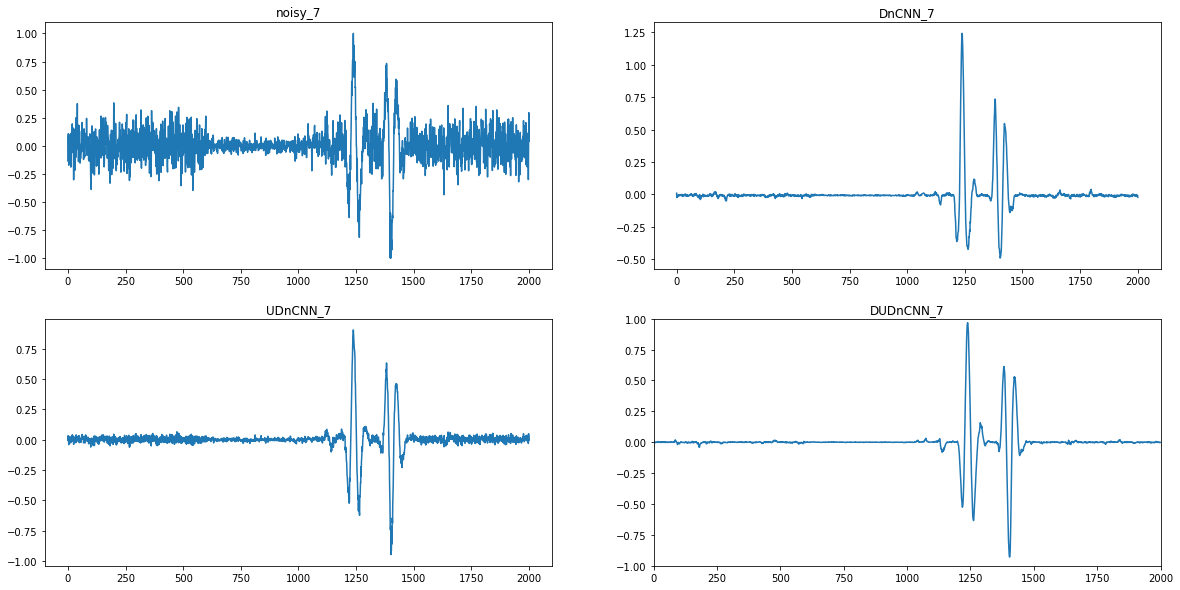

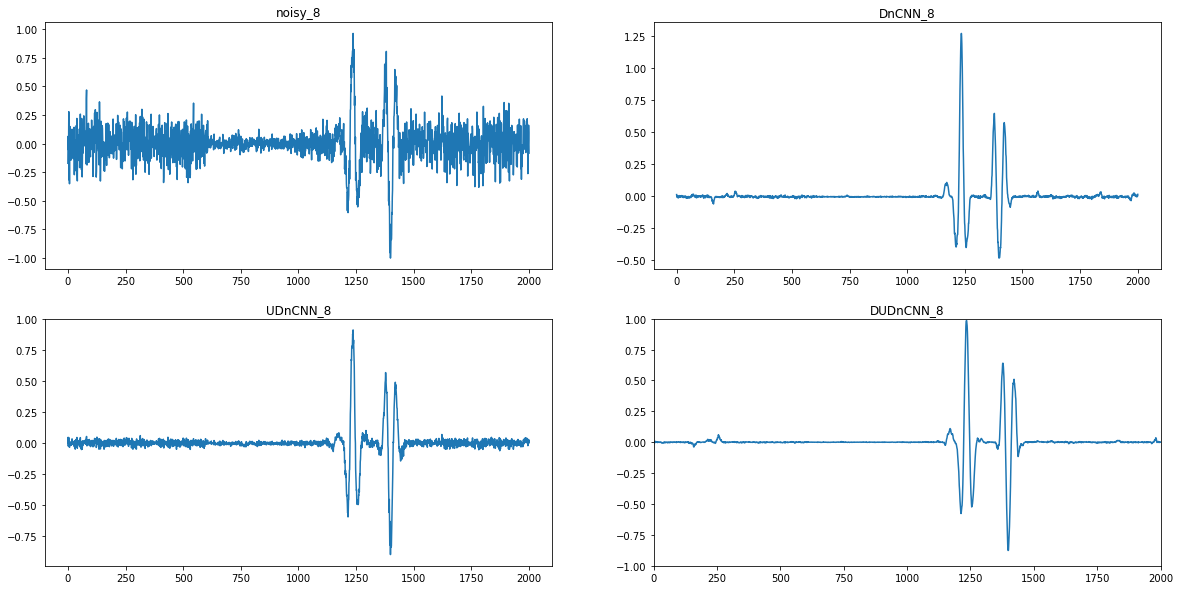

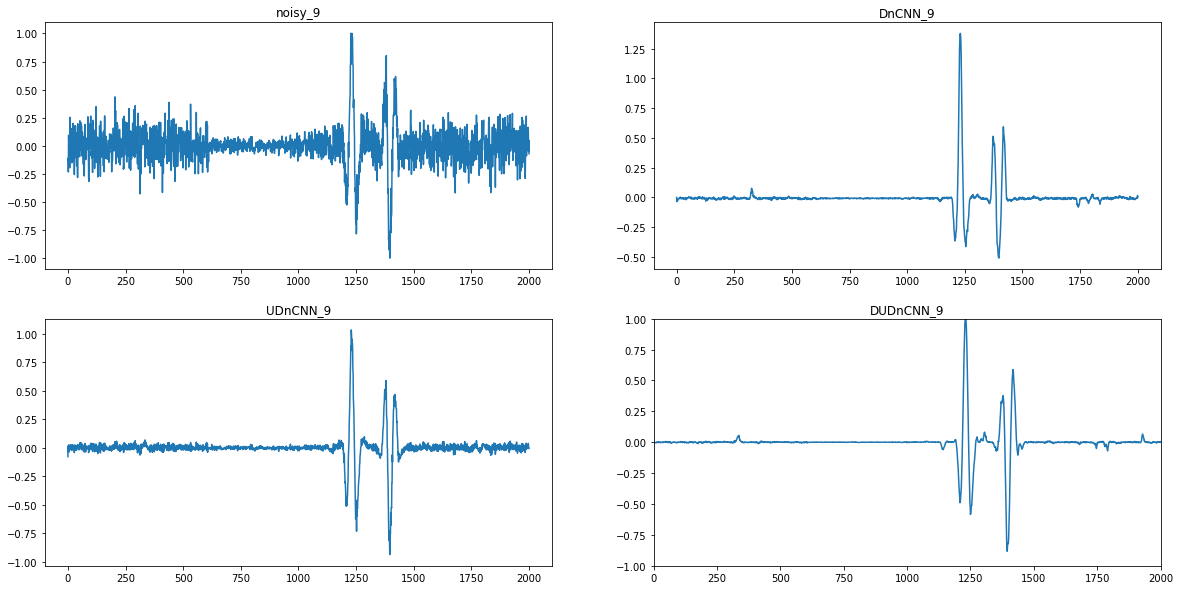

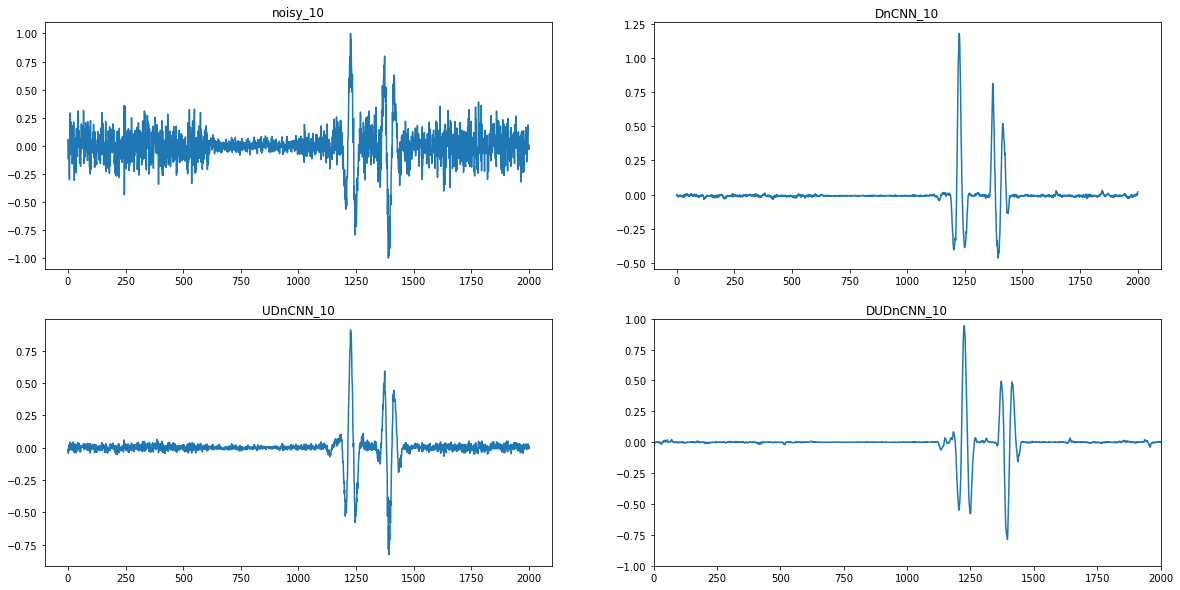

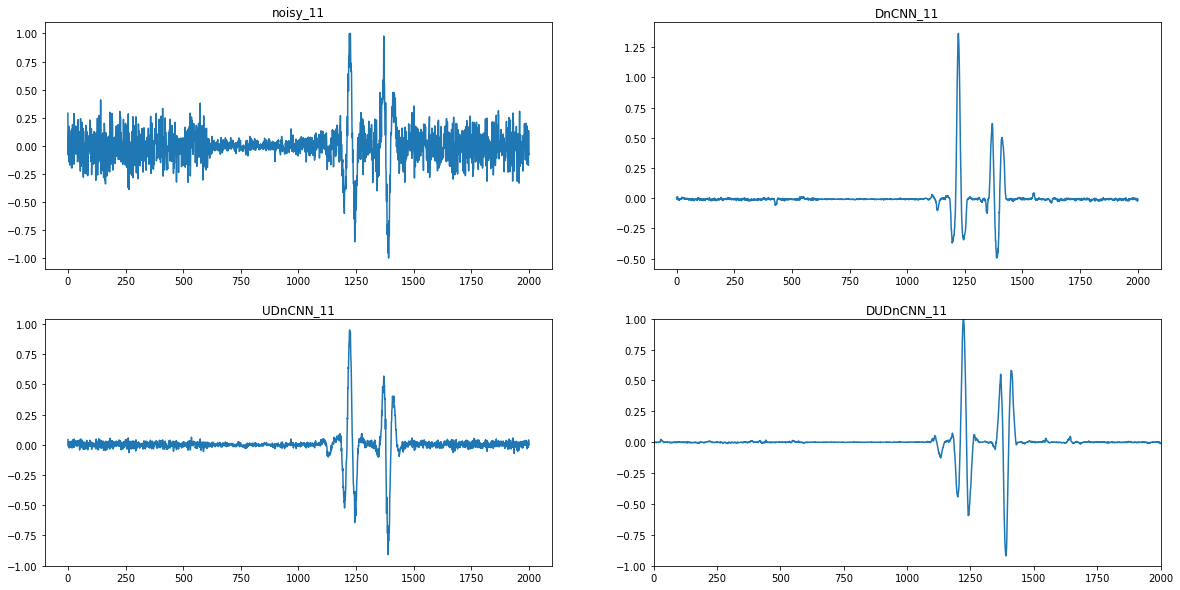

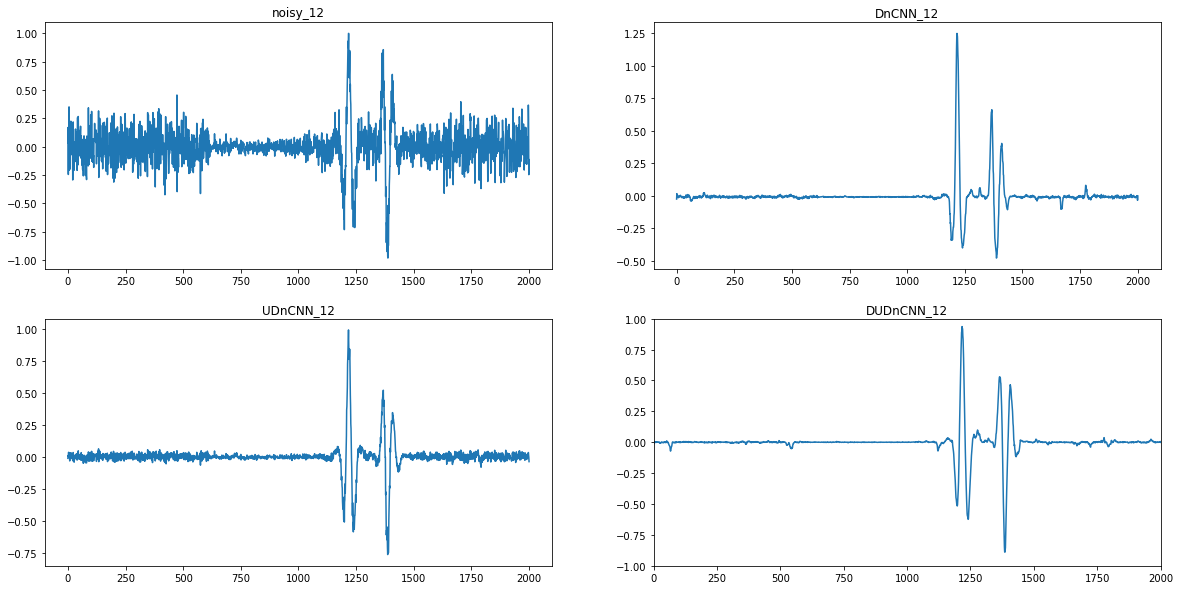

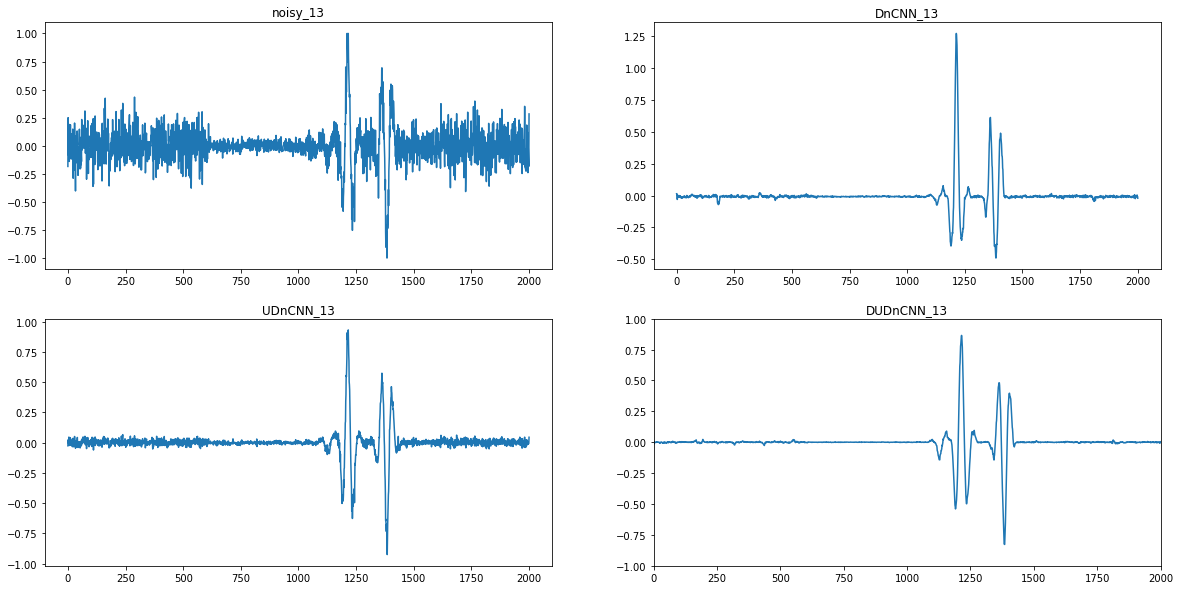

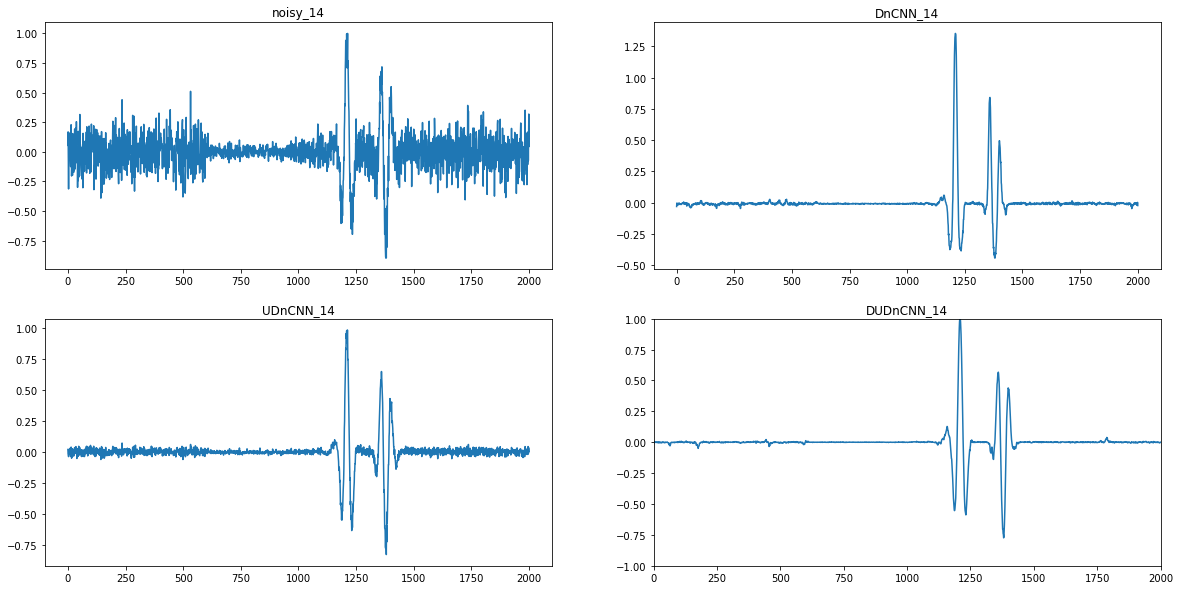

In [735]:
nets = [exp1.net, exp2.net, exp3.net]
titles = ['noisy', 'DnCNN', 'UDnCNN', 'DUDnCNN']
for i in range(len(test_set)):
    noisy, clean = test_set[i]
    noisy = noisy.unsqueeze(0).to(device)
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20,10))
    mysignalshow(noisy[0], axes[0][0])
    axes[0][0].set_title('{}_{}'.format(titles[0], i))
    
    for j in range(3):
        model = nets[j]
        model.eval()
        with torch.no_grad():
            y = model.forward(noisy)
        if(j == 0):
            mysignalshow(y[0], axes[0][1])
            axes[0][1].set_title('{}_{}'.format(titles[j+1], i))
        elif(j == 1):
            mysignalshow(y[0], axes[1][0])
            axes[1][0].set_title('{}_{}'.format(titles[j+1], i))
        else:
            mysignalshow(y[0], axes[1][1])
            axes[1][1].set_title('{}_{}'.format(titles[j+1], i))
    
    plt.savefig(r'C:\Users\bbfss\Desktop\Code\github\Denoising-CNN\重写\结果集\结果集\{}.svg'.format(i))
        